## ISM Homework 4
> b12501031 高紫恩

### Problem, 1.1
In chemical equilibrium, $dn_{H_2}/dt=dn_{CO}/dt=0$ 

Whereas the time evolution of the $H_2$ number density: 
$$\frac{dn_{H_2}}{dt}=R_{dust}n_Hn_{HI}-\Gamma_{H_2}n_{H_2}$$
the time evolution of the $CO$ number density:
$$\frac{dn_{CO}}{dt}=k_0n_C+n_{H_2}\beta-\Gamma_{CO}n_{CO}$$
and the branch ratio $\beta$:
$$\beta=\frac{k_1x_O}{k_1x_O+\Gamma_{CH_x}/n_{H_2}}$$

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

K_B = 1.380649e-16  
M_H = 1.6735575e-24 
n_H_density = 100.0       
T_gas = 30.0              
Z_prime_base = 1.0        # I_UV define by eqch problem

x_C_total_base = 1.4e-4 * Z_prime_base
x_O_total_base = 3.2e-4 * Z_prime_base 
D_prime_base = Z_prime_base            
R_dust_H2_formation_base = 3.0e-17 * D_prime_base
Gamma_H2_photodiss_0_const = 5.68e-11      
AV_NH_conversion_const = 1.87e21            
b5_H2_shielding_const = 2.0                 
k0_CHx_formation_const = 5.0e-16     
Gamma_CO_photodiss_0_const = 2.0e-10 
k1_CO_formation_via_O_const = 5.0e-10 
Gamma_CHx_photodiss_0_const = 5.0e-10 

def h2_self_shielding_factor(N_H2_col, b5):
    if N_H2_col <= 1e-10: 
        return 1.0 
    x = N_H2_col / 5.0e14 
    f = 0.965 / ((1 + x / b5)**2) + (0.035 / np.sqrt(1 + x)) * np.exp(-8.5e-4 * np.sqrt(1 + x))
    return f

def h2_equilibrium_equation(X_H2_frac, N_H_col_arg, 
                            n_H_arg, R_dust_arg, Gamma_H2_0_arg, I_UV_arg, 
                            D_p_arg, AV_conv_arg, b5_arg):
    if X_H2_frac <= 1e-15: 
        return 2 * R_dust_arg * n_H_arg * (1.0 / 1e-15) 
    if X_H2_frac >= 1.0 - 1e-15: 
         X_H2_frac = 1.0 - 1e-15
    A_V = D_p_arg * N_H_col_arg / AV_conv_arg
    f_dust_shielding = np.exp(-3.85 * A_V)
    N_H2_col_density = (X_H2_frac / 2.0) * N_H_col_arg
    f_H2_self_shield = h2_self_shielding_factor(N_H2_col_density, b5_arg)
    Gamma_H2_eff = Gamma_H2_0_arg * I_UV_arg * f_dust_shielding * f_H2_self_shield
    val = 2 * R_dust_arg * n_H_arg * (1.0 - X_H2_frac) / X_H2_frac - Gamma_H2_eff
    return val

def calculate_abundances(N_H_vals_calc, I_UV_field_calc):

    X_H2_eq_arr = np.zeros_like(N_H_vals_calc)
    x_CO_over_xC_eq_arr = np.zeros_like(N_H_vals_calc)

    for i, N_H_col_val_iter in enumerate(N_H_vals_calc):
        args_for_brentq = (N_H_col_val_iter, n_H_density, R_dust_H2_formation_base,
                           Gamma_H2_photodiss_0_const, I_UV_field_calc, D_prime_base,
                           AV_NH_conversion_const, b5_H2_shielding_const)
        try:
            X_H2_eq = brentq(h2_equilibrium_equation, 1e-9, 1.0 - 1e-9, args=args_for_brentq)
        except ValueError:
            if h2_equilibrium_equation(1e-9, *args_for_brentq) < 0:
                 X_H2_eq = 1e-9 
            else: 
                 X_H2_eq = 1.0 -1e-9

        X_H2_eq_arr[i] = X_H2_eq
        
        n_H2_density_val = (X_H2_eq / 2.0) * n_H_density
        A_V_val = D_prime_base * N_H_col_val_iter / AV_NH_conversion_const
        
        Gamma_CO_eff = Gamma_CO_photodiss_0_const * I_UV_field_calc * np.exp(-2.5 * A_V_val)
        Gamma_CHx_eff = Gamma_CHx_photodiss_0_const * I_UV_field_calc * np.exp(-2.5 * A_V_val)
        
        beta_CHx_to_CO = 0.0
        if n_H2_density_val >= 1e-9: 
            denominator_beta = (k1_CO_formation_via_O_const * x_O_total_base + Gamma_CHx_eff / n_H2_density_val)
            if np.abs(denominator_beta) > 1e-99: 
                beta_CHx_to_CO = (k1_CO_formation_via_O_const * x_O_total_base) / denominator_beta
        
        numerator_fCO = k0_CHx_formation_const * n_H2_density_val * beta_CHx_to_CO
        denominator_fCO = Gamma_CO_eff + numerator_fCO
        
        if np.abs(denominator_fCO) < 1e-99: 
            x_CO_over_xC_eq_arr[i] = 0.0
        else:
            x_CO_over_xC_eq_arr[i] = numerator_fCO / denominator_fCO
            
    return X_H2_eq_arr, x_CO_over_xC_eq_arr

N_H_column_densities_global = np.logspace(18, 23, 100) 

def get_shielding_factors_at_transition(N_H_col_trans, X_H2_frac_trans):
    
    A_V = D_prime_base * N_H_col_trans / AV_NH_conversion_const
    f_dust = np.exp(-3.85 * A_V)
    N_H2_col = (X_H2_frac_trans / 2.0) * N_H_col_trans
    f_H2_shield = h2_self_shielding_factor(N_H2_col, b5_H2_shielding_const)
    return A_V, f_dust, N_H2_col, f_H2_shield

print("Setup Cell Executed: Constants, Parameters (for Z'=1), and Functions Defined.")

Setup Cell Executed: Constants, Parameters (for Z'=1), and Functions Defined.


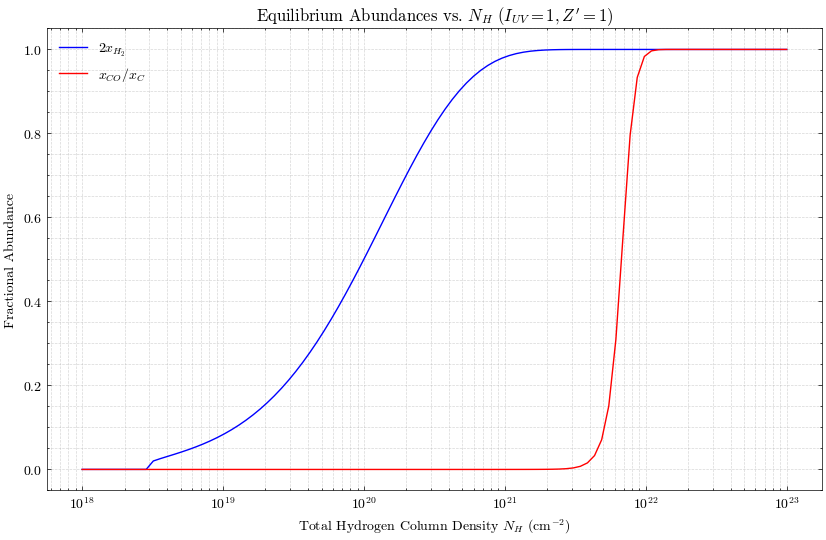

In [20]:
# I_UV = 1.0
I_UV_problem1_1 = 1.0
X_H2_eq_IUV1, x_CO_div_xC_eq_IUV1 = calculate_abundances(N_H_column_densities_global, I_UV_problem1_1)

plt.figure(figsize=(10, 6))
plt.semilogx(N_H_column_densities_global, X_H2_eq_IUV1, label=r'$2x_{H_2}$', color='blue')
plt.semilogx(N_H_column_densities_global, x_CO_div_xC_eq_IUV1, label=r'$x_{CO}/x_C$', color='red')
plt.xlabel(r'Total Hydrogen Column Density $N_H$ (cm$^{-2}$)')
plt.ylabel('Fractional Abundance')
plt.title(r'Equilibrium Abundances vs. $N_H$ ($I_{UV}=1, Z^\prime=1$)')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.ylim(-0.05, 1.05) 
plt.show()

### Problem 1.2

Photon-dominated regions (PDRs) with $I_{UV}=10^3$

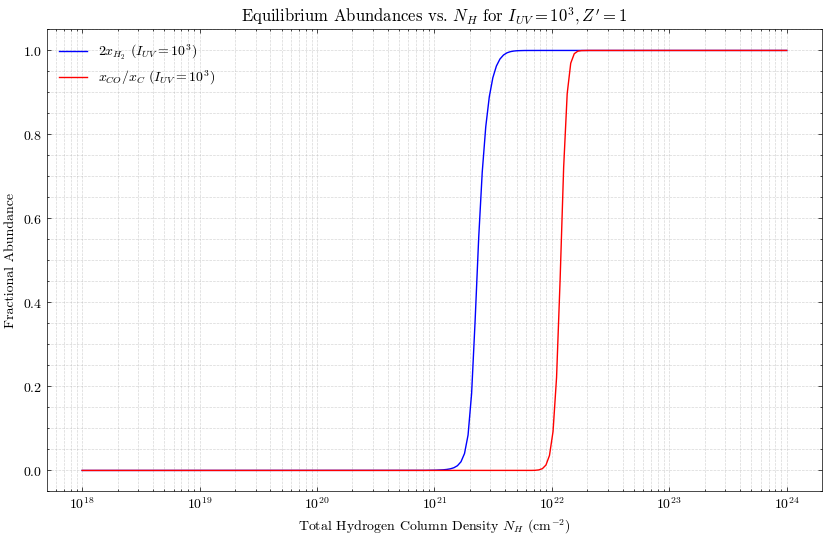

In [21]:
# I_UV = 1000
I_UV_field_1_2 = 1000.0 
X_H2_eq_IUV1000, x_CO_over_xC_eq_IUV1000 = calculate_abundances(N_H_column_densities, I_UV_field_1_2)

plt.figure(figsize=(10, 6))
plt.semilogx(N_H_column_densities, X_H2_eq_IUV1000, label=r'$2x_{H_2}$ ($I_{UV}=10^3$)', color='blue')
plt.semilogx(N_H_column_densities, x_CO_over_xC_eq_IUV1000, label=r'$x_{CO}/x_C$ ($I_{UV}=10^3$)', color='red')
plt.xlabel(r'Total Hydrogen Column Density $N_H$ (cm$^{-2}$)')
plt.ylabel('Fractional Abundance')
plt.title(r'Equilibrium Abundances vs. $N_H$ for $I_{UV}=10^3, Z^\prime=1$')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.ylim(-0.05, 1.05)
plt.show()

#### Discussion of problem 1.2

The relative importance of dust shielding vs. $H_2$ self sheilding at different $I_{UV}$

At low $I_{UV}$ (the radiation is not as strong as 1.2), the dust shielding provides some initial attenuations.
As a moderated $H_2$ column density is achieved, and the $H_2$ self-shielding becomes more important and highly effective.

At high $I_{UV}$, the threshold for $H_2$ formation is pushed higher to $10^{21}\ \mathrm{cm^{-2}}$ hydrogen column density.
Dust shielding becomes more important in order to reduce the strong external UV radiation field.
As $H_2$ starts to form, the $H_2$ self shielding allows the column dnesity to reach high abundance.

### Problem 2.1
Plot the equilibrium abundances of $H_2$ and $CO$ as a functtion of $N_H$ at different metallicities.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
# import scienceplots # Uncomment if you are using this
# plt.style.use(['science', 'no-latex']) # Uncomment if you are using this

# --- Fixed Model Parameters (for the overall model) ---
n_H_density = 100.0       # Hydrogen number density (cm^-3)
# T_gas = 30.0            # Gas temperature (K) - b5 is fixed, so T_gas isn't directly in rate equations
# I_UV_field will be set per problem (e.g., 1.0 for Problem 2.1)

# --- Base Values for Z'-dependent parameters ---
# These are the fundamental coefficients or values when Z'=1 or D'=1.
# The function 'calculate_abundances_for_Zprime' will use these names.
R_dust_H2_formation_base = 3.0e-17 # R_dust coefficient for D'=1 (cm^3 s^-1)
xC_total_base = 1.4e-4             # Fractional C abundance x_C for Z'=1
xO_total_base = 3.2e-4             # Fractional O abundance x_O for Z'=1

# --- Fixed Chemistry and Physics Constants ---
Gamma_H2_photodiss_0 = 5.68e-11      # Base H2 photodissociation rate (s^-1, for I_UV=1, no shielding)
AV_NH_conversion = 1.87e21           # N_H / A_V conversion factor (cm^-2 / mag)
b5_H2_shielding = 2.0                # Fixed Doppler parameter b_5

k0_CHx_formation = 5.0e-16     # Rate coefficient for CH_x formation (cm^3 s^-1)
Gamma_CO_photodiss_0 = 2.0e-10 # Base CO photodissociation rate (s^-1)
k1_CO_formation_via_O = 5.0e-10 # Rate coefficient for CO formation from CH_x + O (cm^3 s^-1)
Gamma_CHx_photodiss_0 = 5.0e-10 # Base CH_x photodissociation rate (s^-1)

# --- Utility Functions (defined once in setup) ---
def h2_self_shielding_factor(N_H2_col, b5_arg_shield): # Renamed b5 to avoid potential scope confusion
    if N_H2_col <= 1e-10: # More robust check for very small/zero N_H2
        return 1.0
    x = N_H2_col / 5.0e14
    f = 0.965 / ((1 + x / b5_arg_shield)**2) + (0.035 / np.sqrt(1 + x)) * np.exp(-8.5e-4 * np.sqrt(1 + x))
    return f

def h2_equilibrium_equation(X_H2_frac, N_H_col_arg,
                            # Parameters passed via brentq args:
                            n_H_func_arg, R_dust_func_arg, Gamma_H2_0_func_arg, I_UV_func_arg,
                            D_p_func_arg, AV_conv_func_arg, b5_func_arg):
    if X_H2_frac <= 1e-15:
        return 2 * R_dust_func_arg * n_H_func_arg * (1.0 / 1e-15)
    if X_H2_frac >= 1.0 - 1e-15:
         X_H2_frac = 1.0 - 1e-15
    A_V = D_p_func_arg * N_H_col_arg / AV_conv_func_arg
    f_dust_shielding = np.exp(-3.85 * A_V)
    N_H2_col_density = (X_H2_frac / 2.0) * N_H_col_arg
    f_H2_self_shield = h2_self_shielding_factor(N_H2_col_density, b5_func_arg)
    Gamma_H2_eff = Gamma_H2_0_func_arg * I_UV_func_arg * f_dust_shielding * f_H2_self_shield
    val = 2 * R_dust_func_arg * n_H_func_arg * (1.0 - X_H2_frac) / X_H2_frac - Gamma_H2_eff
    return val

print("Setup Cell Executed: All constants, base parameters, and utility functions are defined.")

Setup Cell Executed: All constants, base parameters, and utility functions are defined.


Running Problem 2.1 calculations...
  Calculating for Z' = 1.0...
  Calculating for Z' = 0.3...
  Calculating for Z' = 0.1...
  Calculating for Z' = 0.03...
Calculations for Problem 2.1 complete.


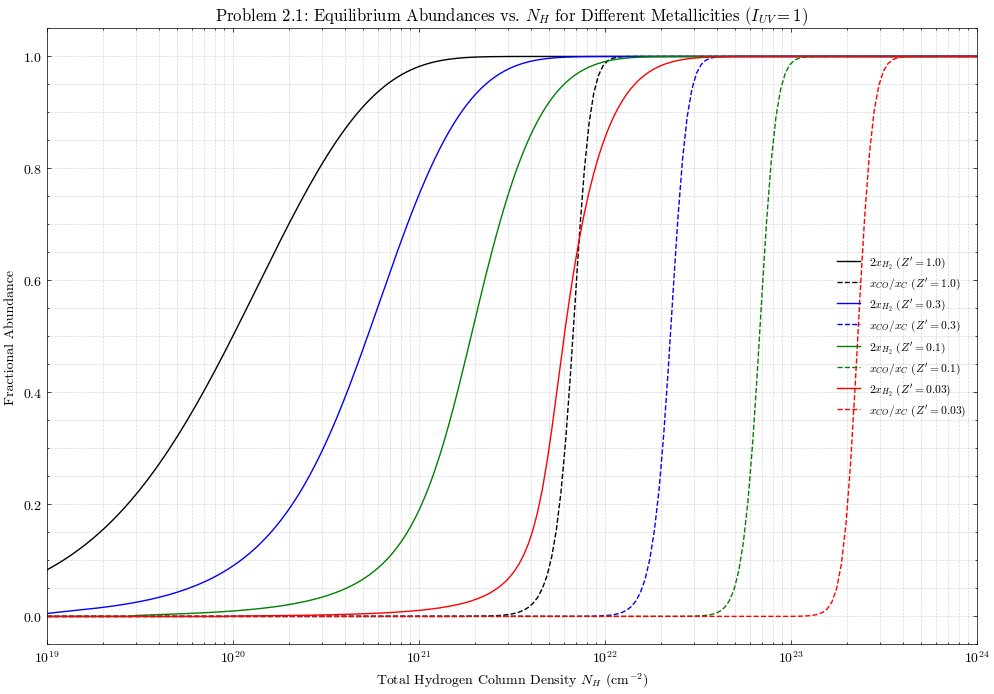

In [28]:
# This cell assumes the Setup Cell (Cell 1) has been executed.

def calculate_abundances_for_Zprime(N_H_vals_calc, current_Z_prime, I_UV_val_calc):
    # Z'-dependent parameters are calculated using 'base' values from Setup Cell
    current_D_prime = current_Z_prime
    # These '..._base' variables MUST be defined in the Setup Cell (Cell 1)
    current_R_dust = R_dust_H2_formation_base * current_D_prime
    current_x_C_total = xC_total_base * current_Z_prime
    current_x_O_total = xO_total_base * current_Z_prime

    X_H2_eq_arr = np.zeros_like(N_H_vals_calc)
    x_CO_over_xC_eq_arr = np.zeros_like(N_H_vals_calc)

    for i, N_H_col_val_iter in enumerate(N_H_vals_calc):
        # Arguments for h2_equilibrium_equation:
        # These use fixed constants from Setup Cell and current Z'-dependent values
        args_for_brentq = (N_H_col_val_iter, n_H_density, current_R_dust,
                           Gamma_H2_photodiss_0, I_UV_val_calc, current_D_prime,
                           AV_NH_conversion, b5_H2_shielding) # Using direct names from setup
        try:
            X_H2_eq = brentq(h2_equilibrium_equation, 1e-9, 1.0 - 1e-9, args=args_for_brentq)
        except ValueError: 
            val_at_low = h2_equilibrium_equation(1e-9, *args_for_brentq)
            val_at_high = h2_equilibrium_equation(1.0-1e-9, *args_for_brentq)
            if val_at_low > 0 and val_at_high < 0:
                 X_H2_eq = 0.5 
            elif val_at_low < 0 :
                 X_H2_eq = 1e-9
            else: 
                 X_H2_eq = 1.0-1e-9

        X_H2_eq_arr[i] = X_H2_eq
        
        n_H2_density_val = (X_H2_eq / 2.0) * n_H_density 
        A_V_val = current_D_prime * N_H_col_val_iter / AV_NH_conversion
        
        Gamma_CO_eff = Gamma_CO_photodiss_0 * I_UV_val_calc * np.exp(-2.5 * A_V_val)
        Gamma_CHx_eff = Gamma_CHx_photodiss_0 * I_UV_val_calc * np.exp(-2.5 * A_V_val)
        
        beta_CHx_to_CO = 0.0
        if n_H2_density_val >= 1e-12 and current_x_O_total >= 1e-12 : 
            # k1_CO_formation_via_O is from Setup Cell
            denominator_beta = (k1_CO_formation_via_O * current_x_O_total + Gamma_CHx_eff / n_H2_density_val)
            if np.abs(denominator_beta) > 1e-99: 
                 beta_CHx_to_CO = (k1_CO_formation_via_O * current_x_O_total) / denominator_beta
        
        # k0_CHx_formation is from Setup Cell
        numerator_fCO = k0_CHx_formation * n_H2_density_val * beta_CHx_to_CO
        denominator_fCO = Gamma_CO_eff + numerator_fCO
        
        if np.abs(denominator_fCO) < 1e-99: 
            x_CO_over_xC_eq_arr[i] = 0.0
        else:
            x_CO_over_xC_eq_arr[i] = numerator_fCO / denominator_fCO
            
    return X_H2_eq_arr, x_CO_over_xC_eq_arr

# --- Parameters for Problem 2.1 Execution ---
N_H_p2_1 = np.logspace(19, 24, 200) # Using your extended range for N_H
Z_primes_p2_1 = [1.0, 0.3, 0.1, 0.03]
I_UV_field_p2_1 = 1.0 # As per Problem 2 conditions (default I_UV=1)

# --- Store results ---
results_H2_p2_1 = {}
results_CO_p2_1 = {}

# --- Loop over metallicities ---
print("Running Problem 2.1 calculations...")
for Z_p_val in Z_primes_p2_1:
    print(f"  Calculating for Z' = {Z_p_val}...")
    X_H2_abundances, CO_abundances = calculate_abundances_for_Zprime(
        N_H_p2_1, Z_p_val, I_UV_field_p2_1
    )
    results_H2_p2_1[Z_p_val] = X_H2_abundances
    results_CO_p2_1[Z_p_val] = CO_abundances
print("Calculations for Problem 2.1 complete.")

# --- Plotting for Problem 2.1 ---
plt.figure(figsize=(12, 8))
colors = ['black', 'blue', 'green', 'red']

for i, Z_p_val_plot in enumerate(Z_primes_p2_1): # Use a different loop variable for clarity
    plt.semilogx(N_H_p2_1, results_H2_p2_1[Z_p_val_plot], 
                 label=fr'$2x_{{H_2}}\ (Z^\prime={Z_p_val_plot})$', 
                 color=colors[i], linestyle='-')
    plt.semilogx(N_H_p2_1, results_CO_p2_1[Z_p_val_plot], 
                 label=fr'$x_{{CO}}/x_C\ (Z^\prime={Z_p_val_plot})$', 
                 color=colors[i], linestyle='--')

plt.xlabel(r'Total Hydrogen Column Density $N_H$ (cm$^{-2}$)')
plt.ylabel('Fractional Abundance')
plt.title(r'Problem 2.1: Equilibrium Abundances vs. $N_H$ for Different Metallicities ($I_{UV}=1$)')
plt.legend(fontsize='small', loc='center right')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.ylim(-0.05, 1.05)
plt.xlim(min(N_H_p2_1), max(N_H_p2_1)) 
plt.show()

### Problem 2.2

Running Problem 2.2 plotting: Abundances vs. A_V...


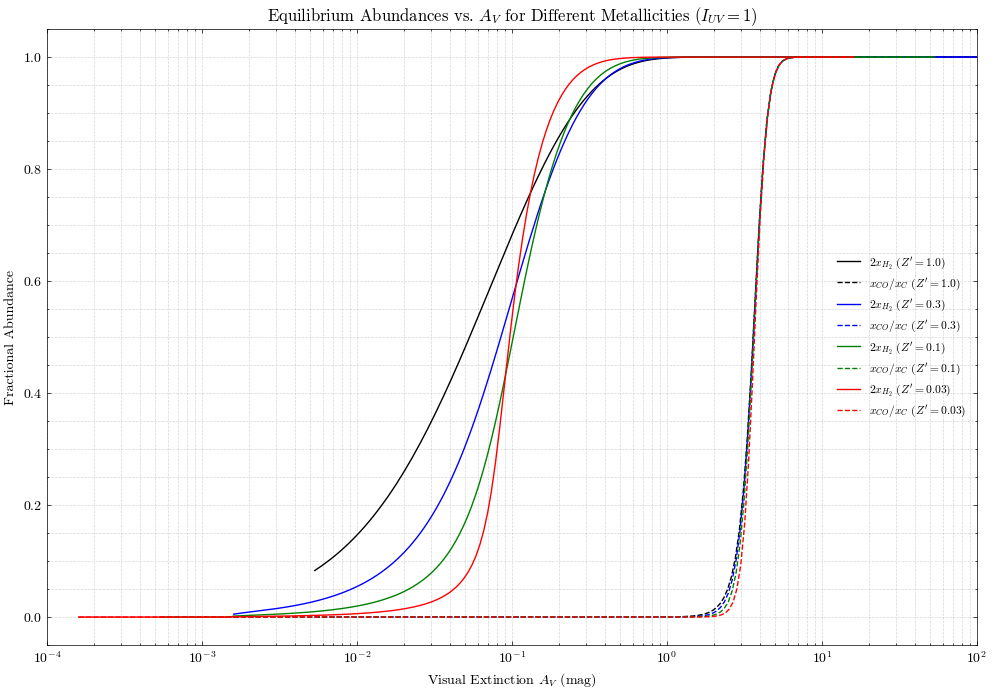

Problem 2.2 plotting complete.


In [37]:
print("Running Problem 2.2 plotting: Abundances vs. A_V...")


plt.figure(figsize=(12, 8))

if 'colors' not in globals() and 'colors' not in locals():
    colors = ['black', 'blue', 'green', 'red'] 

min_av_plot_limit = float('inf')
max_av_plot_limit = float('-inf')

for i, Z_p_val in enumerate(Z_primes_p2_1):
    current_D_prime = Z_p_val
    AV_values = current_D_prime * N_H_p2_1 / AV_NH_conversion_const
    positive_av_values = AV_values[AV_values > 0]
    if len(positive_av_values) > 0:
        min_av_plot_limit = min(min_av_plot_limit, np.min(positive_av_values))
        max_av_plot_limit = max(max_av_plot_limit, np.max(positive_av_values))

    if Z_p_val in results_H2_p2_1:
        plt.semilogx(AV_values, results_H2_p2_1[Z_p_val], 
                     label=fr'$2x_{{H_2}}\ (Z^\prime={Z_p_val})$', 
                     color=colors[i % len(colors)], linestyle='-') 
    
    if Z_p_val in results_CO_p2_1: 
        plt.semilogx(AV_values, results_CO_p2_1[Z_p_val], 
                     label=fr'$x_{{CO}}/x_C\ (Z^\prime={Z_p_val})$', 
                     color=colors[i % len(colors)], linestyle='--') 

plt.xlabel(r'Visual Extinction $A_V$ (mag)')
plt.ylabel('Fractional Abundance')
plt.title(r'Equilibrium Abundances vs. $A_V$ for Different Metallicities ($I_{UV}=1$)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles)) 
plt.legend(by_label.values(), by_label.keys(), fontsize='small', loc='center right')

plt.grid(True, which="both", ls="--", alpha=0.5)
plt.ylim(-0.05, 1.05)

if np.isinf(min_av_plot_limit) or np.isinf(max_av_plot_limit) or min_av_plot_limit <= 0:
    plt.xlim(1e-4, 100) # Fallback x-limits
    print("Warning: Could not determine optimal A_V plot limits from data. Using default.")
else:
    plot_xmin = max(1e-4, min_av_plot_limit * 0.5) 
    plot_xmax = min(100, max_av_plot_limit * 1.5) 
    if plot_xmin < plot_xmax:
        plt.xlim(plot_xmin, plot_xmax)
    else: 
        plt.xlim(1e-4,100)
plt.show()
print("Problem 2.2 plotting complete.")

### Problem 2.3

In [35]:
delta_AV_values_p2_3 = []
summary_data_p2_3 = [] 
target_abundance = 0.5 

for Z_p_val in Z_primes_p2_1:
    h2_abundances = results_H2_p2_1[Z_p_val]
    co_abundances = results_CO_p2_1[Z_p_val]
    
    N_H_H2_trans = np.nan
    N_H_CO_trans = np.nan

    if np.any(h2_abundances >= target_abundance): 
        h2_cross_indices = np.where(h2_abundances >= target_abundance)[0]
        if len(h2_cross_indices) > 0:
            h2_idx = h2_cross_indices[0]
            if h2_idx == 0: 
                N_H_H2_trans = N_H_p2_1[0] if h2_abundances[0] >= target_abundance else np.nan
            elif h2_abundances[h2_idx] > h2_abundances[h2_idx-1]: 
                N_H_H2_trans = np.interp(
                    target_abundance,
                    [h2_abundances[h2_idx-1], h2_abundances[h2_idx]],
                    [N_H_p2_1[h2_idx-1], N_H_p2_1[h2_idx]]
                )
            elif h2_abundances[h2_idx] >= target_abundance : 
                N_H_H2_trans = N_H_p2_1[h2_idx]

    if np.any(co_abundances >= target_abundance): 
        co_cross_indices = np.where(co_abundances >= target_abundance)[0]
        if len(co_cross_indices) > 0:
            co_idx = co_cross_indices[0]
            if co_idx == 0: 
                N_H_CO_trans = N_H_p2_1[0] if co_abundances[0] >= target_abundance else np.nan
            elif co_abundances[co_idx] > co_abundances[co_idx-1]: 
                N_H_CO_trans = np.interp(
                    target_abundance,
                    [co_abundances[co_idx-1], co_abundances[co_idx]],
                    [N_H_p2_1[co_idx-1], N_H_p2_1[co_idx]]
                )
            elif co_abundances[co_idx] >= target_abundance : 
                N_H_CO_trans = N_H_p2_1[co_idx]

    A_V_H2_trans = np.nan
    A_V_CO_trans = np.nan
    delta_A_V = np.nan

    current_D_prime = Z_p_val # D' = Z'

    if not np.isnan(N_H_H2_trans):
        A_V_H2_trans = current_D_prime * N_H_H2_trans / AV_NH_conversion_const
    if not np.isnan(N_H_CO_trans):
        A_V_CO_trans = current_D_prime * N_H_CO_trans / AV_NH_conversion_const
    
    if not np.isnan(A_V_H2_trans) and not np.isnan(A_V_CO_trans):
        if A_V_CO_trans >= A_V_H2_trans:
             delta_A_V = A_V_CO_trans - A_V_H2_trans
        else: 
             delta_A_V = np.nan 
             print(f"  Warning for Z'={Z_p_val}: CO transition A_V ({A_V_CO_trans:.3f}) is less than H2 transition A_V ({A_V_H2_trans:.3f}). Delta A_V set to NaN.")


    delta_AV_values_p2_3.append(delta_A_V)
    summary_data_p2_3.append({
        "Z_prime": Z_p_val,
        "N_H_H2_trans": N_H_H2_trans,
        "N_H_CO_trans": N_H_CO_trans,
        "A_V_H2_trans": A_V_H2_trans,
        "A_V_CO_trans": A_V_CO_trans,
        "Delta_A_V": delta_A_V
    })

    print(f"\nFor Z' = {Z_p_val}:")
    print(f"  N_H (H2 trans., 2x_H2=0.5)  = {N_H_H2_trans:.2e} cm^-2")
    print(f"  N_H (CO trans., x_CO/x_C=0.5) = {N_H_CO_trans:.2e} cm^-2")
    print(f"  A_V (H2 trans.)            = {A_V_H2_trans:.3f} mag")
    print(f"  A_V (CO trans.)            = {A_V_CO_trans:.3f} mag")
    print(f"  Delta A_V (A_V,CO - A_V,H2) = {delta_A_V:.3f} mag")

print("\n--- Summary of Delta A_V ---")
for Z_idx, Z_p_val_summary in enumerate(Z_primes_p2_1):
    print(f"  Z' = {Z_p_val_summary:<4}: Delta A_V = {delta_AV_values_p2_3[Z_idx]:.3f} mag")

valid_delta_AVs = [val for val in delta_AV_values_p2_3 if not np.isnan(val)]
if len(valid_delta_AVs) > 1: # Need at least 2 points for std dev
    mean_delta_AV = np.mean(valid_delta_AVs)
    std_delta_AV = np.std(valid_delta_AVs)
    print(f"\nMean Delta A_V = {mean_delta_AV:.3f} mag")
    print(f"Std Dev Delta A_V = {std_delta_AV:.3f} mag")
    if mean_delta_AV > 0 and (std_delta_AV / mean_delta_AV) < 0.3: 
        print("Delta A_V appears to be relatively insensitive to metallicity within the calculated range.")
    else:
        print("Delta A_V shows notable variation or could not be reliably assessed for insensitivity.")
elif len(valid_delta_AVs) == 1:
    print(f"\nOnly one valid Delta A_V calculated ({valid_delta_AVs[0]:.3f} mag), cannot assess sensitivity robustly.")
else:
    print("\nCould not calculate Delta A_V for enough metallicities to assess sensitivity (transitions might be out of N_H range).")


For Z' = 1.0:
  N_H (H2 trans., 2x_H2=0.5)  = 9.97e+19 cm^-2
  N_H (CO trans., x_CO/x_C=0.5) = 6.73e+21 cm^-2
  A_V (H2 trans.)            = 0.053 mag
  A_V (CO trans.)            = 3.598 mag
  Delta A_V (A_V,CO - A_V,H2) = 3.545 mag

For Z' = 0.3:
  N_H (H2 trans., 2x_H2=0.5)  = 5.29e+20 cm^-2
  N_H (CO trans., x_CO/x_C=0.5) = 2.25e+22 cm^-2
  A_V (H2 trans.)            = 0.085 mag
  A_V (CO trans.)            = 3.605 mag
  Delta A_V (A_V,CO - A_V,H2) = 3.521 mag

For Z' = 0.1:
  N_H (H2 trans., 2x_H2=0.5)  = 1.91e+21 cm^-2
  N_H (CO trans., x_CO/x_C=0.5) = 6.78e+22 cm^-2
  A_V (H2 trans.)            = 0.102 mag
  A_V (CO trans.)            = 3.624 mag
  Delta A_V (A_V,CO - A_V,H2) = 3.522 mag

For Z' = 0.03:
  N_H (H2 trans., 2x_H2=0.5)  = 6.04e+21 cm^-2
  N_H (CO trans., x_CO/x_C=0.5) = 2.29e+23 cm^-2
  A_V (H2 trans.)            = 0.097 mag
  A_V (CO trans.)            = 3.674 mag
  Delta A_V (A_V,CO - A_V,H2) = 3.577 mag

--- Summary of Delta A_V ---
  Z' = 1.0 : Delta A_V = 3.54

#### Discussion for problem 2.3
 - For $Z'=1.0,\ \Delta A_V=3.545\ \mathrm{mag}$
 - For $Z'=0.3,\ \Delta A_V=3.521\ \mathrm{mag}$
 - For $Z'=0.1,\ \Delta A_V=3.522\ \mathrm{mag}$
 - For $Z'=0.03,\ \Delta A_V=3.577\ \mathrm{mag}$

 The mean $\Delta A_V=3.541\ \mathrm{mag}$ with a small standard deviation, showing that $\Delta A_V$ is insensitive to matallicity.

##### How this affects the metallicity dependence of "$CO$-dark" gas fraction and the $CO$-to-$H_2$ conversion factor:
 
 $$A_V=\frac{D'N_H}{C_{AV}}$$
 As the metallicity decreases, the column density of $CO$ dark $H_2$ gas increases significantly.

For the column density of hydrogen in $CO$-dark gas:
$$\Delta N_{H,\ dark}=N_{H,\ CO}-N_{H,\ H_2}=\left(A_{V,\ CO}C_{AV}/Z'\right)-\left(A_{V,\ H_2}C_{AV}/Z'\right)=\Delta A_{V}\times C_{AV}/Z'$$
Implies that the column density of $CO$-to-$H_2$ scales as $1/Z'$

As for the conversion factor ($X_{CO}$),
$$N(H_2)=X_{CO}W_{CO}$$
the $X_{CO}$ increases with decreasing metallicity.




### Problem 2.4

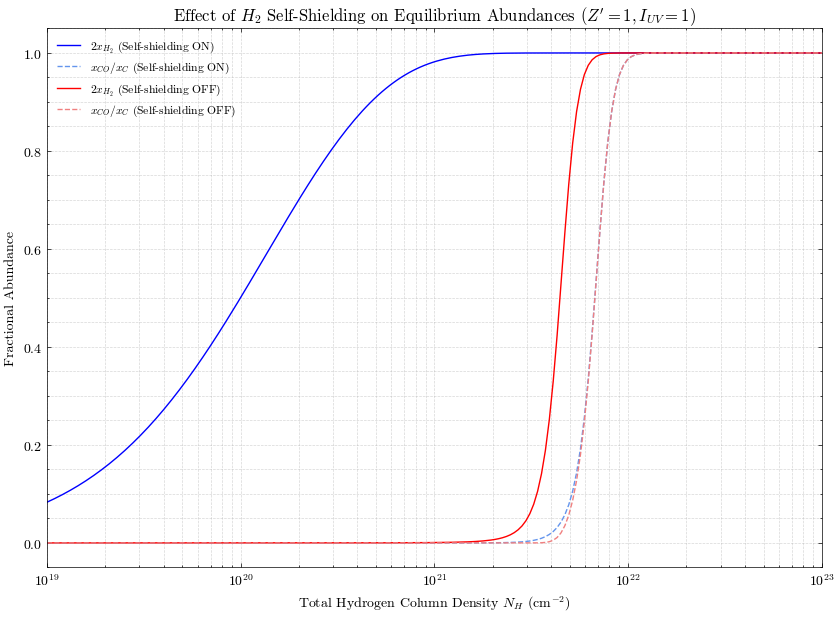

In [41]:
n_H_density = 100.0       
I_UV_field = 1.0          
Z_prime_2_4 = 1.0         

def h2_self_shielding_factor_original(N_H2_col, b5):
    if N_H2_col <= 1e-10:
        return 1.0
    x = N_H2_col / 5.0e14
    term1 = 0.965 / ((1 + x / b5)**2)
    term2 = (0.035 / np.sqrt(1 + x)) * np.exp(-8.5e-4 * np.sqrt(1 + x))
    return term1 + term2

def h2_equilibrium_equation_shielding_toggle(X_H2_frac, N_H_col, n_H, R_dust_val, Gamma_H2_0, I_UV,
                                             D_prime_val, AV_conv, b5, self_shielding_enabled=True):
    if X_H2_frac <= 1e-15:
        return 2 * R_dust_val * n_H * (1.0 / 1e-15)
    if X_H2_frac >= 1.0 - 1e-15:
         X_H2_frac = 1.0 - 1e-15

    A_V = D_prime_val * N_H_col / AV_conv
    f_dust_shielding = np.exp(-3.85 * A_V) # Dust shielding factor for H2
    
    if self_shielding_enabled:
        N_H2_col_density = (X_H2_frac / 2.0) * N_H_col
        f_H2_self_shield = h2_self_shielding_factor_original(N_H2_col_density, b5)
    else:
        f_H2_self_shield = 1.0 # H2 self-shielding disabled
    
    Gamma_H2_eff = Gamma_H2_0 * I_UV * f_dust_shielding * f_H2_self_shield
    val = 2 * R_dust_val * n_H * (1.0 - X_H2_frac) / X_H2_frac - Gamma_H2_eff
    return val

# --- Function to calculate abundances for a given Z_prime and shielding status ---
def calculate_abundances_shielding_toggle(N_H_vals, current_Z_prime, I_UV_val, self_shielding_enabled=True):
    current_D_prime = current_Z_prime
    current_R_dust = R_dust_H2_formation_base * current_D_prime
    current_x_C_total = xC_total_base * current_Z_prime # Total carbon abundance
    current_x_O_total = xO_total_base * current_Z_prime # Total oxygen abundance

    X_H2_eq_arr = np.zeros_like(N_H_vals)
    x_CO_over_xC_eq_arr = np.zeros_like(N_H_vals)

    for i, N_H_col_val in enumerate(N_H_vals):
        try:
            X_H2_eq = brentq(h2_equilibrium_equation_shielding_toggle, 1e-9, 1.0 - 1e-9,
                             args=(N_H_col_val, n_H_density, current_R_dust,
                                   Gamma_H2_photodiss_0, I_UV_val, current_D_prime,
                                   AV_NH_conversion, b5_H2_shielding, self_shielding_enabled))
        except ValueError:
            # Basic fallback
            val_at_low = h2_equilibrium_equation_shielding_toggle(1e-9, N_H_col_val, n_H_density, current_R_dust, Gamma_H2_photodiss_0, I_UV_val, current_D_prime, AV_NH_conversion, b5_H2_shielding, self_shielding_enabled)
            if val_at_low < 0 : X_H2_eq = 1e-9
            else: X_H2_eq = 1.0-1e-9
        X_H2_eq_arr[i] = X_H2_eq
        
        n_H2_density_val = (X_H2_eq / 2.0) * n_H_density
        A_V_val = current_D_prime * N_H_col_val / AV_NH_conversion
        
        # CO photodissociation rate includes dust shielding
        Gamma_CO_eff = Gamma_CO_photodiss_0 * I_UV_val * np.exp(-2.5 * A_V_val)
        # CHx photodissociation rate includes dust shielding
        Gamma_CHx_eff = Gamma_CHx_photodiss_0 * I_UV_val * np.exp(-2.5 * A_V_val)
        
        if n_H2_density_val < 1e-12 or current_x_O_total < 1e-12 :
            beta_CHx_to_CO = 0.0
        else:
            # Branching ratio for CO formation
            denominator_beta = (k1_CO_formation_via_O * current_x_O_total + Gamma_CHx_eff / n_H2_density_val)
            if denominator_beta < 1e-99: beta_CHx_to_CO = 0.0
            else: beta_CHx_to_CO = (k1_CO_formation_via_O * current_x_O_total) / denominator_beta
        
        numerator_fCO = k0_CHx_formation * n_H2_density_val * beta_CHx_to_CO
        denominator_fCO = Gamma_CO_eff + numerator_fCO
        
        if denominator_fCO < 1e-99:
            x_CO_over_xC_eq_arr[i] = 0.0
        else:
            x_CO_over_xC_eq_arr[i] = numerator_fCO / denominator_fCO
            
    return X_H2_eq_arr, x_CO_over_xC_eq_arr

N_H_column_densities_2_4 = np.logspace(19, 23, 200) 

X_H2_shield_enabled, CO_shield_enabled = calculate_abundances_shielding_toggle(
    N_H_column_densities_2_4, Z_prime_2_4, I_UV_field, self_shielding_enabled=True)

X_H2_shield_disabled, CO_shield_disabled = calculate_abundances_shielding_toggle(
    N_H_column_densities_2_4, Z_prime_2_4, I_UV_field, self_shielding_enabled=False)

plt.figure(figsize=(10, 7))
plt.semilogx(N_H_column_densities_2_4, X_H2_shield_enabled, color='blue', linestyle='-', label=r'$2x_{H_2}$ (Self-shielding ON)')
plt.semilogx(N_H_column_densities_2_4, CO_shield_enabled, color='cornflowerblue', linestyle='--', label=r'$x_{CO}/x_C$ (Self-shielding ON)')
plt.semilogx(N_H_column_densities_2_4, X_H2_shield_disabled, color='red', linestyle='-', label=r'$2x_{H_2}$ (Self-shielding OFF)')
plt.semilogx(N_H_column_densities_2_4, CO_shield_disabled, color='lightcoral', linestyle='--', label=r'$x_{CO}/x_C$ (Self-shielding OFF)')
plt.xlabel(r'Total Hydrogen Column Density $N_H$ (cm$^{-2}$)')
plt.ylabel('Fractional Abundance')
plt.title(r'Effect of $H_2$ Self-Shielding on Equilibrium Abundances ($Z^\prime=1, I_{UV}=1$)')
plt.legend(fontsize='small')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.ylim(-0.05, 1.05)
plt.xlim(min(N_H_column_densities_2_4), max(N_H_column_densities_2_4))
plt.show()

### Discussion of problem 2.4

By disabling the $H_2$ self shielding, the column density of hydrogen shifted much higher ($10^{21}$) than the self-shielding on. Showing that $H_2$ self-shielding is a critical process for formation and survival of molecular hydrogen.

### Problem 3.1

Problem 3.1: Running simulations for Z' = 1.0...
  N_H = 1.00e+19 cm^-2 (1/50)
  N_H = 6.55e+19 cm^-2 (11/50)
  N_H = 4.29e+20 cm^-2 (21/50)
  N_H = 2.81e+21 cm^-2 (31/50)
  N_H = 1.84e+22 cm^-2 (41/50)
Problem 3.1: Running simulations for Z' = 0.3...
  N_H = 1.00e+19 cm^-2 (1/50)
  N_H = 6.55e+19 cm^-2 (11/50)
  N_H = 4.29e+20 cm^-2 (21/50)
  N_H = 2.81e+21 cm^-2 (31/50)
  N_H = 1.84e+22 cm^-2 (41/50)
Problem 3.1: Running simulations for Z' = 0.1...
  N_H = 1.00e+19 cm^-2 (1/50)
  N_H = 6.55e+19 cm^-2 (11/50)
  N_H = 4.29e+20 cm^-2 (21/50)
  N_H = 2.81e+21 cm^-2 (31/50)
  N_H = 1.84e+22 cm^-2 (41/50)
Problem 3.1: Running simulations for Z' = 0.03...
  N_H = 1.00e+19 cm^-2 (1/50)
  N_H = 6.55e+19 cm^-2 (11/50)
  N_H = 4.29e+20 cm^-2 (21/50)
  N_H = 2.81e+21 cm^-2 (31/50)
  N_H = 1.84e+22 cm^-2 (41/50)
Problem 3.1 calculations complete.


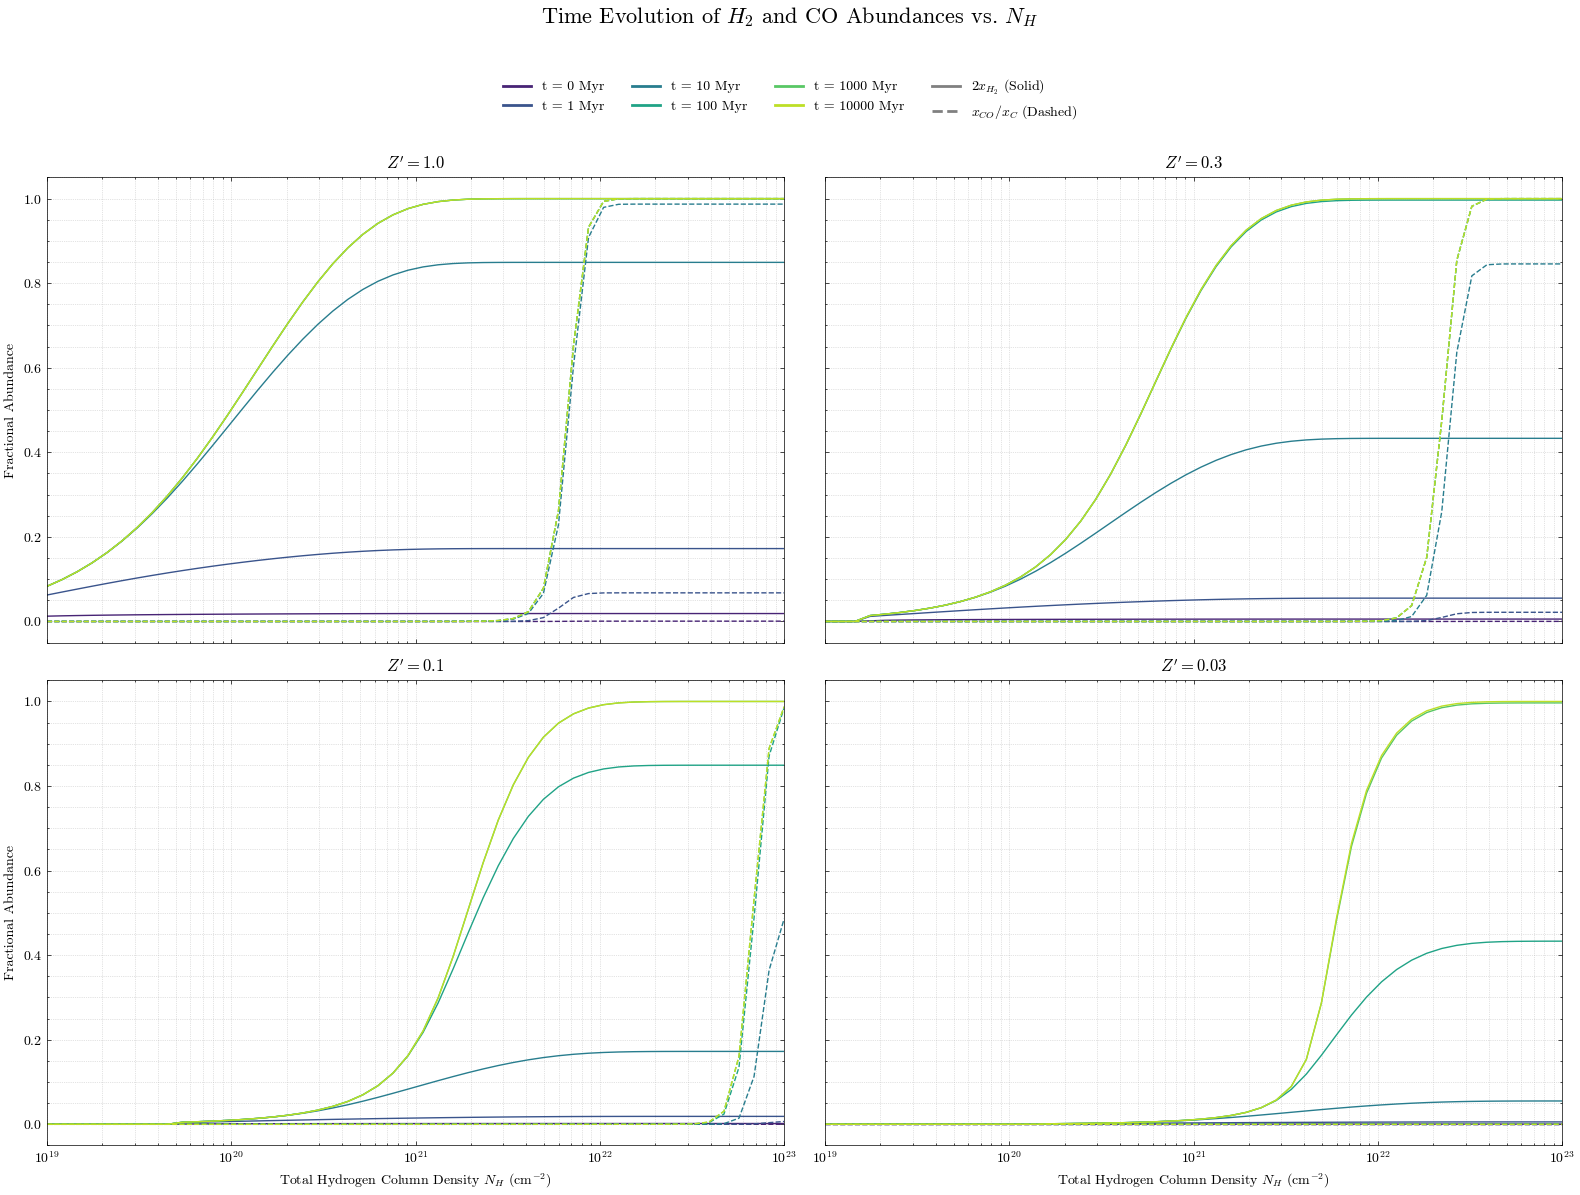

In [42]:
from scipy.constants import year as year_in_seconds 

def chemical_network_odes_p3_1(t, y_abund, 
                               N_H_col_val, n_H_total_val, current_Z_prime_val, I_UV_val):
    n_H2, n_CO = y_abund
    n_H2 = max(1e-40, n_H2) 
    n_CO = max(0, n_CO)
    D_prime_val_ode = current_Z_prime_val
    R_dust_val_ode = R_dust_H2_formation_base * D_prime_val_ode 
    current_x_C_ode = xC_total_base * current_Z_prime_val
    current_x_O_ode = xO_total_base * current_Z_prime_val
    n_HI_val = n_H_total_val - 2 * n_H2
    n_HI_val = max(0, n_HI_val)
    A_V_ode = D_prime_val_ode * N_H_col_val / AV_NH_conversion
    f_dust_H2_ode = np.exp(-3.85 * A_V_ode)
    N_H2_col_for_shielding_ode = (n_H2 / n_H_total_val) * N_H_col_val if n_H_total_val > 0 else 0
    f_H2_self_ode = h2_self_shielding_factor(N_H2_col_for_shielding_ode, b5_H2_shielding)
    Gamma_H2_eff_ode = Gamma_H2_photodiss_0 * I_UV_val * f_dust_H2_ode * f_H2_self_ode
    dnH2_dt = R_dust_val_ode * n_H_total_val * n_HI_val - Gamma_H2_eff_ode * n_H2
    n_C_total_density_ode = current_x_C_ode * n_H_total_val
    n_C_plus_ode = n_C_total_density_ode - n_CO
    n_C_plus_ode = max(0, n_C_plus_ode)
    f_dust_CO_CHx_ode = np.exp(-2.5 * A_V_ode)
    Gamma_CO_eff_ode = Gamma_CO_photodiss_0 * I_UV_val * f_dust_CO_CHx_ode
    Gamma_CHx_eff_ode = Gamma_CHx_photodiss_0 * I_UV_val * f_dust_CO_CHx_ode
    beta_val_ode = 0.0
    beta_denominator_ode = (k1_CO_formation_via_O * current_x_O_ode + Gamma_CHx_eff_ode / n_H2)

    if np.abs(beta_denominator_ode) > 1e-99 : 
        beta_val_ode = (k1_CO_formation_via_O * current_x_O_ode) / beta_denominator_ode
        
    dnCO_dt = k0_CHx_formation * n_C_plus_ode * n_H2 * beta_val_ode - Gamma_CO_eff_ode * n_CO
    
    return [dnH2_dt, dnCO_dt]

N_H_vals_p3_1 = np.logspace(19, 23, 50)  
Z_primes_p3_1 = [1.0, 0.3, 0.1, 0.03]
times_myr_p3_1 = np.array([0.1, 1, 10, 100, 1000, 10000]) # Times in Myr
times_sec_p3_1 = times_myr_p3_1 * 1e6 * year_in_seconds  # Convert Myr to seconds

I_UV_field_p3_1 = 1.0 
n_H2_initial_abs = 1e-20 * n_H_density 
n_CO_initial_abs = 1e-20 

results_2xH2_p3_1 = {Zp: np.zeros((len(times_myr_p3_1), len(N_H_vals_p3_1))) for Zp in Z_primes_p3_1}
results_xCO_div_xC_p3_1 = {Zp: np.zeros((len(times_myr_p3_1), len(N_H_vals_p3_1))) for Zp in Z_primes_p3_1}

for Z_idx, Z_p_iter in enumerate(Z_primes_p3_1):
    print(f"Problem 3.1: Running simulations for Z' = {Z_p_iter}...")
    current_x_C_total_for_norm = xC_total_base * Z_p_iter 
    
    for NH_idx, NH_val_iter in enumerate(N_H_vals_p3_1):
        if NH_idx % 10 == (len(N_H_vals_p3_1)//10 // 10 * 10): 
            print(f"  N_H = {NH_val_iter:.2e} cm^-2 ({NH_idx+1}/{len(N_H_vals_p3_1)})")
            
        y0_p3_1 = [n_H2_initial_abs, n_CO_initial_abs] 
        
        sol = solve_ivp(
            chemical_network_odes_p3_1, 
            [0, times_sec_p3_1[-1]], 
            y0_p3_1,
            args=(NH_val_iter, n_H_density, Z_p_iter, I_UV_field_p3_1),
            t_eval=times_sec_p3_1,    
            method='Radau',          
            rtol=1e-5,                
            atol=1e-20              
        )
        
        for t_idx in range(len(times_myr_p3_1)):
            n_H2_at_t = sol.y[0, t_idx]
            n_CO_at_t = sol.y[1, t_idx]
            n_H2_at_t = np.clip(n_H2_at_t, 0, n_H_density / 2.0)
            n_CO_at_t = np.clip(n_CO_at_t, 0, current_x_C_total_for_norm * n_H_density) 

            results_2xH2_p3_1[Z_p_iter][t_idx, NH_idx] = 2 * (n_H2_at_t / n_H_density)
            if current_x_C_total_for_norm > 1e-15: # Avoid division by zero for x_C
                 results_xCO_div_xC_p3_1[Z_p_iter][t_idx, NH_idx] = \
                     (n_CO_at_t / n_H_density) / current_x_C_total_for_norm
            else:
                 results_xCO_div_xC_p3_1[Z_p_iter][t_idx, NH_idx] = 0.0
print("Problem 3.1 calculations complete.")

fig_p3_1, axes_p3_1 = plt.subplots(2, 2, figsize=(16, 12), sharex=True, sharey=True)
axes_p3_1 = axes_p3_1.flatten() 
plot_colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(times_myr_p3_1)))

for i, Z_p_plot in enumerate(Z_primes_p3_1):
    ax = axes_p3_1[i]
    for t_idx, t_val_myr_plot in enumerate(times_myr_p3_1):
        # Plot H2
        ax.semilogx(N_H_vals_p3_1, results_2xH2_p3_1[Z_p_plot][t_idx, :],
                    color=plot_colors[t_idx], linestyle='-',
                    label=f'$2x_{{H_2}}$ t={t_val_myr_plot:.0f} Myr' if i==0 and Z_idx==0 else None) # Legend handle from first plot only
        # Plot CO
        ax.semilogx(N_H_vals_p3_1, results_xCO_div_xC_p3_1[Z_p_plot][t_idx, :],
                    color=plot_colors[t_idx], linestyle='--',
                    label=f'$x_{{CO}}/x_C$ t={t_val_myr_plot:.0f} Myr' if i==0 and Z_idx==0 else None) 
    
    ax.set_title(f'$Z^\prime = {Z_p_plot}$')
    ax.grid(True, which="both", ls=":", alpha=0.7)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlim(min(N_H_vals_p3_1), max(N_H_vals_p3_1)) 
    
    if i >= 2: 
        ax.set_xlabel(r'Total Hydrogen Column Density $N_H$ (cm$^{-2}$)')
    if i % 2 == 0: # Left column panels
        ax.set_ylabel('Fractional Abundance')

from matplotlib.lines import Line2D
legend_elements_p3_1 = []
for t_idx, t_val_myr_plot in enumerate(times_myr_p3_1):
    legend_elements_p3_1.append(Line2D([0], [0], color=plot_colors[t_idx], lw=2, label=f't = {t_val_myr_plot:.0f} Myr'))
legend_elements_p3_1.append(Line2D([0], [0], color='grey', linestyle='-', lw=2, label='$2x_{H_2}$ (Solid)'))
legend_elements_p3_1.append(Line2D([0], [0], color='grey', linestyle='--', lw=2, label='$x_{CO}/x_C$ (Dashed)'))

fig_p3_1.legend(handles=legend_elements_p3_1, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.98))
fig_p3_1.suptitle('Time Evolution of $H_2$ and CO Abundances vs. $N_H$', fontsize=16, y=1.03)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle and legend
plt.show()

### Problem 3.2

In [46]:
def analytical_timescale_H2(Z_prime_val, n_H_val, R_dust_base_coeff):
    R_dust_effective = R_dust_base_coeff * Z_prime_val
    if R_dust_effective == 0 or n_H_val == 0:
        return np.inf
    t_seconds = 1.0 / (2.0 * R_dust_effective * n_H_val)
    return t_seconds / (1e6 * year_in_seconds) # Convert to Myr

def analytical_timescale_CO_intrinsic(n_H_val, k0_coeff):
    if k0_coeff == 0 or n_H_val == 0:
        return np.inf
    t_seconds = 2.0 / (k0_coeff * n_H_val)
    return t_seconds / (1e6 * year_in_seconds) # Convert to Myr

print("\nAnalytical Timescales:")
analytical_t_H2_results = {}
for Z_p_calc in Z_primes_p3_1:
    t_h2_analytical = analytical_timescale_H2(Z_p_calc, n_H_density, R_dust_H2_formation_base)
    analytical_t_H2_results[Z_p_calc] = t_h2_analytical
    print(f"  For Z' = {Z_p_calc:<4}: Analytical t_H2 ~ {t_h2_analytical:.2f} Myr")

t_co_analytical_intrinsic = analytical_timescale_CO_intrinsic(n_H_density, k0_CHx_formation)
print(f"  Intrinsic Analytical t_CO (once H2 abundant, beta approx 1) ~ {t_co_analytical_intrinsic:.2f} Myr (Z'-independent in this approximation)")
print("\nNumerical Timescales (time to reach 50% of abundance at t=10^4 Myr, for high N_H):")

idx_high_NH = -1 
N_H_for_timescale_check = N_H_vals_p3_1[idx_high_NH]
print(f"(Using N_H = {N_H_for_timescale_check:.2e} cm^-2 for numerical estimates)")

target_fraction_of_equilibrium = 0.5 

for Z_p_calc in Z_primes_p3_1:
    h2_abund_time_series = results_2xH2_p3_1[Z_p_calc][:, idx_high_NH]
    h2_eq_numerical = h2_abund_time_series[-1] # Value at 10^4 Myr
    target_h2 = target_fraction_of_equilibrium * h2_eq_numerical
    t_h2_numerical_myr = np.nan

    if h2_eq_numerical > 1e-3: 
        if h2_abund_time_series[0] >= target_h2:
            t_h2_numerical_myr = times_myr_p3_1[0]
        elif h2_abund_time_series[-1] < target_h2: 
            t_h2_numerical_myr = np.inf
        else:
            for k_h2 in range(len(h2_abund_time_series)):
                if h2_abund_time_series[k_h2] >= target_h2:
                    if k_h2 == 0:
                        t_h2_numerical_myr = times_myr_p3_1[0]
                    else: # Linear interpolation
                        t1, y1 = times_myr_p3_1[k_h2-1], h2_abund_time_series[k_h2-1]
                        t2, y2 = times_myr_p3_1[k_h2],   h2_abund_time_series[k_h2]
                        if (y2 - y1) > 1e-9: # Avoid division by zero if flat
                            t_h2_numerical_myr = t1 + (t2 - t1) * (target_h2 - y1) / (y2 - y1)
                        else:
                            t_h2_numerical_myr = t2 # Reached at this point
                    break
    
    co_abund_time_series = results_xCO_div_xC_p3_1[Z_p_calc][:, idx_high_NH]
    co_eq_numerical = co_abund_time_series[-1] # Value at 10^4 Myr
    target_co = target_fraction_of_equilibrium * co_eq_numerical
    t_co_numerical_myr = np.nan

    if co_eq_numerical > 1e-3: # Proceed if equilibrium value is significant
        if co_abund_time_series[0] >= target_co:
            t_co_numerical_myr = times_myr_p3_1[0]
        elif co_abund_time_series[-1] < target_co: # Not reached
            t_co_numerical_myr = np.inf
        else:
            for k_co in range(len(co_abund_time_series)):
                if co_abund_time_series[k_co] >= target_co:
                    if k_co == 0:
                        t_co_numerical_myr = times_myr_p3_1[0]
                    else: # Linear interpolation
                        t1, y1 = times_myr_p3_1[k_co-1], co_abund_time_series[k_co-1]
                        t2, y2 = times_myr_p3_1[k_co],   co_abund_time_series[k_co]
                        if (y2 - y1) > 1e-9:
                            t_co_numerical_myr = t1 + (t2 - t1) * (target_co - y1) / (y2 - y1)
                        else:
                            t_co_numerical_myr = t2
                    break
                            
    print(f"  For Z' = {Z_p_calc:<4}: Numerical t_H2 ~ {t_h2_numerical_myr:.2f} Myr. "
          f"Numerical t_CO ~ {t_co_numerical_myr:.2f} Myr.")


Analytical Timescales:
  For Z' = 1.0 : Analytical t_H2 ~ 5.28 Myr
  For Z' = 0.3 : Analytical t_H2 ~ 17.62 Myr
  For Z' = 0.1 : Analytical t_H2 ~ 52.85 Myr
  For Z' = 0.03: Analytical t_H2 ~ 176.17 Myr
  Intrinsic Analytical t_CO (once H2 abundant, beta approx 1) ~ 1.27 Myr (Z'-independent in this approximation)

Numerical Timescales (time to reach 50% of abundance at t=10^4 Myr, for high N_H):
(Using N_H = 1.00e+23 cm^-2 for numerical estimates)
  For Z' = 1.0 : Numerical t_H2 ~ 5.36 Myr. Numerical t_CO ~ 5.23 Myr.
  For Z' = 0.3 : Numerical t_H2 ~ 20.68 Myr. Numerical t_CO ~ 6.22 Myr.
  For Z' = 0.1 : Numerical t_H2 ~ 53.56 Myr. Numerical t_CO ~ 11.39 Myr.
  For Z' = 0.03: Numerical t_H2 ~ 206.81 Myr. Numerical t_CO ~ nan Myr.


### Problem 3.3
#### Comparison of Chemical and Dynamical Timescales
The non-equilibrium effect to the "$CO$-dark" gas fraction and $X_{CO}$, given a typical cloud lifetime is $t_{dyn}\approx 10\ \mathrm{Myr}$

For $X'=1.0,\ t_{H_2}\approx 5.3\ \mathrm{Myr}$, $H_2$ can form to a significant extent. However, to lower metallicities, the $t_{H_2}$ is longer than the $t_{dyn}$. Also, the $t_{CO}$ is limited by $H_2$ formation.

When $t_{H_2}$ or $t_{CO}$ is $\geq$ $t_{dyn}$, the abundance of $H_2$ and $CO$ would not reach the equilibrium before the clouds disperses.

At $Z'=1.0$, the $H_2$ could form within $10\ \mathrm{Myr}$, the $CO$ formation might catch up. Where the plot shows the $2x_{H_2}$ is substantial but $x_{CO}/x_C$ is still relatively low. This increases the $CO$-dark gas fraction beyond the equilibrium $\Delta A_V$ layer.

At low metallicities, the effect is more dramatic. Since $t_{H_2} > t_{dyn}$, $H_2$ would be significantly under-abundant compare to the equilibrium potential. As for $CO$, it forms even slower due to the dependence on $H_2$.

#### Implications for the $CO$-to-$H_2$ conversion factor
$$N(H_2)=X_{CO}W_{CO}$$
> where $W_{CO}$ is the integrated $CO$ line intensity

If $CO$ is underabundant relative to $H_2$ due to non-equilibrium effects, the $CO$ emission ($W_{CO}$) will be weaker for a given true column density of $H_2$. 
To accurately estimate the total $H_2$ mass, a larger $X_{CO}$ factor is required. Non-equilibrium effects inherently lead to an increase in the $X_{CO}$ factor.

The very long chemical timescales for $H_2$ formation and subsequently for effective $CO$ formation ensure that $H_2$ and $CO$ are far from equilibrium. This results in significantly higher $X_{CO}$ values in low-$Z'$ environments compared to the typical Galactic value.




